In [1]:
#Importing all the neccesary libraries
import numpy as np 
import pandas as pd 
import csv

import os
print(os.listdir("input"))

import regex as re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# for clustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete, average, weighted
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score

['.ipynb_checkpoints', '951967.zip', 'Bug report 10.csv', 'Bug report 100.csv', 'Bug report.csv', 'preprocessed_data.csv']


In [2]:
data=pd.read_csv('Input/Bug report.csv')
data = data.reset_index()
data.head()

,index,Summary,Description
0,0,[DEV] Admin can add user permissions with end ...,SDET tried to test endpoint for happy case : ...
1,1,[DEV] Missing Input Validation for Endpoint Ad...,SDET tried to test endpoint for negative case ...
2,2,[STG][PP][Launcher][Recharge] There's ellipsis...,-
3,3,[DEV][AP][VersusEvil] Registered User not coun...,Registered User not count in Daily Active User...
4,4,[DEV] Fix Issues for Endpoint Admin Delete Use...,SDET tried to test endpoint DELETE /iam/v3/adm...


In [3]:
data.isnull().sum()

index          0
Summary        0
Description    0
dtype: int64

**Text data preprocessing steps**

1- Data Cleaning(either using regex or BeautifulSoup): 
a) Removing HTML characters. 
b) Removing punctuation. 
c) Decoding encoded data.
d) Split attached words.
e) Removing URLs. 
f) Apostrophe removal.
g) Removing Expressions. 
h) Uppercase & Lowercase letters 
i) Numbers such as amounts and data.

2- Data Tokenization(using word_tokenize in nltk.tokenize) 
Segregation of text into individual words i.e tokens.

3- Stopword Removal(using stopwords in nltk.corpus)
Discarding too common words or words which are not going to be helpful in our analysis.

4- Stemming(using WordNetLemmatizer in nltk.stem) 
Combining different variants of words into a single parent word that conveys same meaning.

In [4]:
stops = set(stopwords.words("english"))

In [5]:
data['Concat'] = data.Summary + data.Description
data.to_csv("./Output/data_concat.csv")

In [6]:
def clean_Description(content):
#     content = table.Description
    #Converting text to lowercase characters
    content = content.apply(lambda x: x.lower())
    #Removing HTML tags
    content = content.apply(lambda x: re.sub(r'\<[^<>]*\>','',x))
    #Removing any character which does not match to letter,digit or underscore
    content = content.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    #Removing space,newline,tab
    content = content.apply(lambda x: re.sub(r'\s',' ',x))
    #Removing punctuation
    content = content.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    #Removing numeric
    content = content.apply(lambda x: re.sub(r'[0-9]','',x))
    #Tokenizing data
    content = content.apply(lambda x: word_tokenize(x))
    #Removing stopwords
    content = content.apply(lambda x: [i for i in x if i not in stops])
    type(content)
    return(content)

In [7]:
data.Concat = clean_Description(data.Concat)

In [8]:
data.head()

,index,Summary,Description,Concat
0,0,[DEV] Admin can add user permissions with end ...,SDET tried to test endpoint for happy case : ...,"[dev, add, permissions, end, colon, resource, ..."
1,1,[DEV] Missing Input Validation for Endpoint Ad...,SDET tried to test endpoint for negative case ...,"[dev, missing, input, validation, endpoint, ad..."
2,2,[STG][PP][Launcher][Recharge] There's ellipsis...,-,"[stg, pp, launcher, recharge, ellipsis, symbol..."
3,3,[DEV][AP][VersusEvil] Registered User not coun...,Registered User not count in Daily Active User...,"[dev, ap, registered, count, daily, active, lo..."
4,4,[DEV] Fix Issues for Endpoint Admin Delete Use...,SDET tried to test endpoint DELETE /iam/v3/adm...,"[dev, fix, issues, endpoint, delete, rolessdet..."


In [9]:
desc = ' '
for x in data.Concat:
    for y in x:
        desc+=' '+y

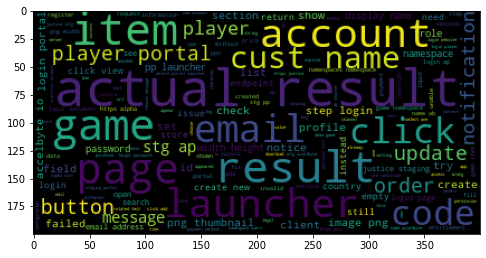

In [10]:
plt.figure(figsize=(8,10))
wc = WordCloud(max_words=1000,random_state=1).generate(desc)
plt.imshow(wc)
plt.show()

## Stemming

In [11]:
data.dtypes

index           int64
Summary        object
Description    object
Concat         object
dtype: object

In [12]:
wordnet = WordNetLemmatizer()
data.Concat = data.Concat.apply(lambda x:[wordnet.lemmatize(i,pos='v') for i in x])

# snowball = SnowballStemmer("porter")
# data.Concat = data.Concat.apply(lambda x:[snowball.stem(i) for i in x])

In [13]:
data.head()

,index,Summary,Description,Concat
0,0,[DEV] Admin can add user permissions with end ...,SDET tried to test endpoint for happy case : ...,"[dev, add, permissions, end, colon, resource, ..."
1,1,[DEV] Missing Input Validation for Endpoint Ad...,SDET tried to test endpoint for negative case ...,"[dev, miss, input, validation, endpoint, add, ..."
2,2,[STG][PP][Launcher][Recharge] There's ellipsis...,-,"[stg, pp, launcher, recharge, ellipsis, symbol..."
3,3,[DEV][AP][VersusEvil] Registered User not coun...,Registered User not count in Daily Active User...,"[dev, ap, register, count, daily, active, logi..."
4,4,[DEV] Fix Issues for Endpoint Admin Delete Use...,SDET tried to test endpoint DELETE /iam/v3/adm...,"[dev, fix, issue, endpoint, delete, rolessdet,..."


In [14]:
Summary = data.Concat.astype(str)
listOfSummary = list(data.Concat)

# Hiearchical Clustering

## Jaccard Coeffient

In [15]:
import itertools
def compute_jaccard(str1, str2):
    himpunan1 = set(str1)
    himpunan2 = set(str2)
    irisan = himpunan1.intersection(himpunan2)
    gabungan = himpunan1.union(himpunan2)
    jaccard = len(irisan)/float(len(gabungan))
    
    return jaccard

In [16]:
sim_df = pd.DataFrame()

for col_pair in itertools.combinations_with_replacement(listOfSummary,2):
    strOfCol = str(col_pair)
    
    u0 = col_pair[0]
    u1 = col_pair[1]
    sim_df.loc[str(col_pair[0]), str(col_pair[1])] = compute_jaccard(u0, u1)

In [17]:
sim_df = sim_df.fillna(0)

In [18]:
dist = np.array(sim_df)
print(dist)

[[1.         0.35555556 0.         ... 0.06122449 0.         0.06122449]
 [0.         1.         0.         ... 0.01612903 0.         0.01612903]
 [0.         0.         1.         ... 0.05714286 0.         0.05714286]
 ...
 [0.         0.         0.         ... 1.         0.02941176 0.17391304]
 [0.         0.         0.         ... 0.         1.         0.12903226]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [19]:
# ndist = dist[:, ~np.isnan(dist).any(axis=0)]
# # print(ndist)

In [20]:
np.savetxt("./Output/distance_matrix.csv", dist, delimiter=",")

## Agglomerative Hierarchical Clustering

In [21]:
linkage_matrix = weighted(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

## Visualization

Dendrogram visualization. We visualize the titles of each paper next to the corresponding leaf to qualitatively evaluate the clustering.

Changing the `color_threshold` kwarg in the call to `dendrogram()` will affect how the clusters are displayed by increasing or decreasing the 
minimum distance necessary for `dendrogram()` to color a cluster differently.

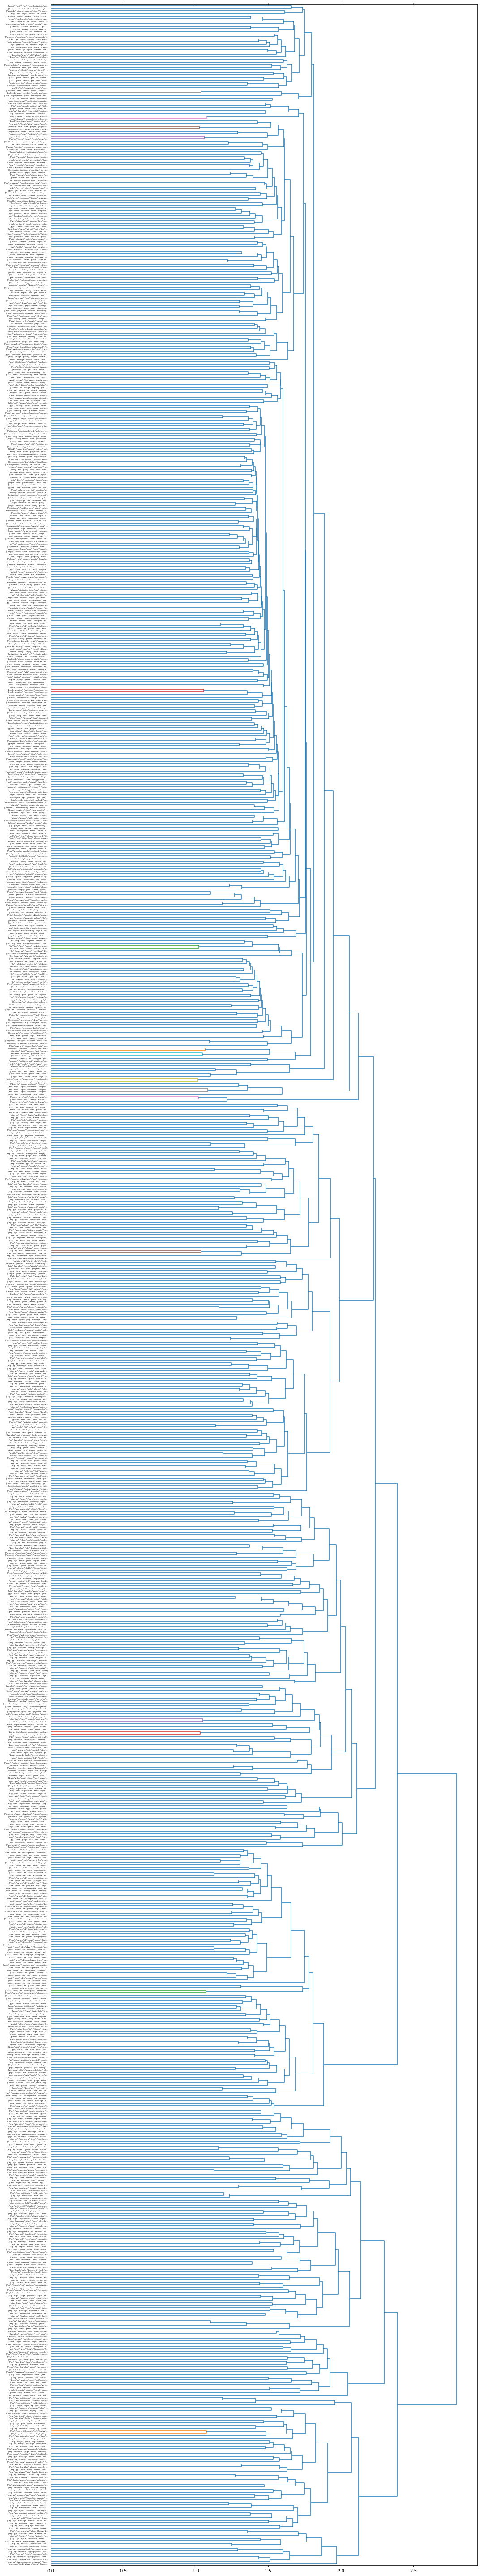

In [22]:
sys.setrecursionlimit(10000)
MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
MAX_TITLE_LEN = 50

fig, ax = plt.subplots(figsize=(15, 80)) # set size
ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4, labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('./Output/jaccard-coeff-weighted.png', dpi=300)

# Analysis

We now take the raw clusters achieved and use the silhouette score and elbow method to evaluate.

In [23]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores
    

Silhouette score with 2 clusters: -0.5231254520171452
Silhouette score with 3 clusters: -0.5649140053750302
Silhouette score with 4 clusters: -0.6926594492831212
Silhouette score with 5 clusters: -0.824971104121171
Silhouette score with 6 clusters: -0.8613334487061813
Silhouette score with 7 clusters: -0.8797469970330803
Silhouette score with 8 clusters: -0.880384582598437
Silhouette score with 9 clusters: -0.8794162625173536
Silhouette score with 10 clusters: -0.9044470097886586
Silhouette score with 11 clusters: -0.9214394384540238
Silhouette score with 12 clusters: -0.9769821841491062
Silhouette score with 13 clusters: -0.97641992264349
Silhouette score with 14 clusters: -0.9759995679529561
Silhouette score with 15 clusters: -0.9749995679529561
Silhouette score with 16 clusters: -0.9806223045793613
Silhouette score with 17 clusters: -0.9807914144313338
Silhouette score with 18 clusters: -0.9798362469018892
Silhouette score with 19 clusters: -0.9787844410459604
Silhouette score with 

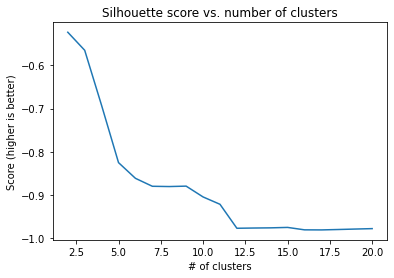

In [24]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)

 # Hierarchical Clustering Using Jaccard Coefficient and IDF

In [25]:
def calc_DF(tfDict):
    count_DF = {}
    # Run through each document's tf dictionary and increment countDict's (term, doc) pair
    for document in tfDict:
        for term in document:
            if term in count_DF:
                count_DF[term] += 1
            else:
                count_DF[term] = 1
    return count_DF

DF = calc_DF(listOfSummary)

In [26]:
with open('./Output/MyDFDict.csv', 'w') as f:
    for key in DF.keys():
        f.write("%s,%s\n"%(key,DF[key]))

In [27]:
n_document = len(listOfSummary)

def calc_IDF(__n_document, __DF):
    IDF_Dict = {}
    for term in __DF:
        IDF_Dict[term] = np.log(__n_document / (__DF[term] + 1))
    return IDF_Dict
  
#Stores the idf dictionary
IDF = calc_IDF(n_document, DF)

In [28]:
with open('./Output/MyIDFDict.csv', 'w') as f:
    for key in IDF.keys():
        f.write("%s,%s\n"%(key,IDF[key]))

In [29]:
def compute_jaccard(str1, str2):
    himpunan1 = set(str1)
    himpunan2 = set(str2)
    irisan = himpunan1.intersection(himpunan2)
    IDF_VAL = 0.0
    for key in irisan:
        IDF_VAL = IDF_VAL + IDF[key]
    if len(irisan) == 0:
        IDF_VAL = 1
    else:
        IDF_VAL = IDF_VAL/(len(irisan)+1)
    gabungan = himpunan1.union(himpunan2)
#     jaccard = IDF_VAL
    jaccard = len(irisan)/float(len(gabungan)) * IDF_VAL
    
    return jaccard

In [30]:
import itertools

sim_df = pd.DataFrame()

for col_pair in itertools.combinations_with_replacement(listOfSummary,2):
    strOfCol = str(col_pair)
    
    u0 = col_pair[0]
    u1 = col_pair[1]
    sim_df.loc[str(col_pair[0]), str(col_pair[1])] = compute_jaccard(u0, u1)

In [31]:
sim_df = sim_df.fillna(0)

In [32]:
dist = np.array(sim_df)

print(dist)

[[2.66453204 0.75173031 0.         ... 0.07394028 0.         0.0779397 ]
 [0.         2.83908205 0.         ... 0.01352134 0.         0.01562856]
 [0.         0.         2.42700798 ... 0.03033347 0.         0.03716564]
 ...
 [0.         0.         0.         ... 3.00026539 0.00438832 0.25681163]
 [0.         0.         0.         ... 0.         2.01177568 0.13571452]
 [0.         0.         0.         ... 0.         0.         2.02138961]]


In [33]:
sim_df.to_csv("./Output/jcidf_matrix.csv")

## Agglomerative Hierarchical Clustering

In [34]:
linkage_matrix = weighted(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

## Visualization

Dendrogram visualization. We visualize the titles of each paper next to the corresponding leaf to qualitatively evaluate the clustering.

Changing the `color_threshold` kwarg in the call to `dendrogram()` will affect how the clusters are displayed by increasing or decreasing the 
minimum distance necessary for `dendrogram()` to color a cluster differently.

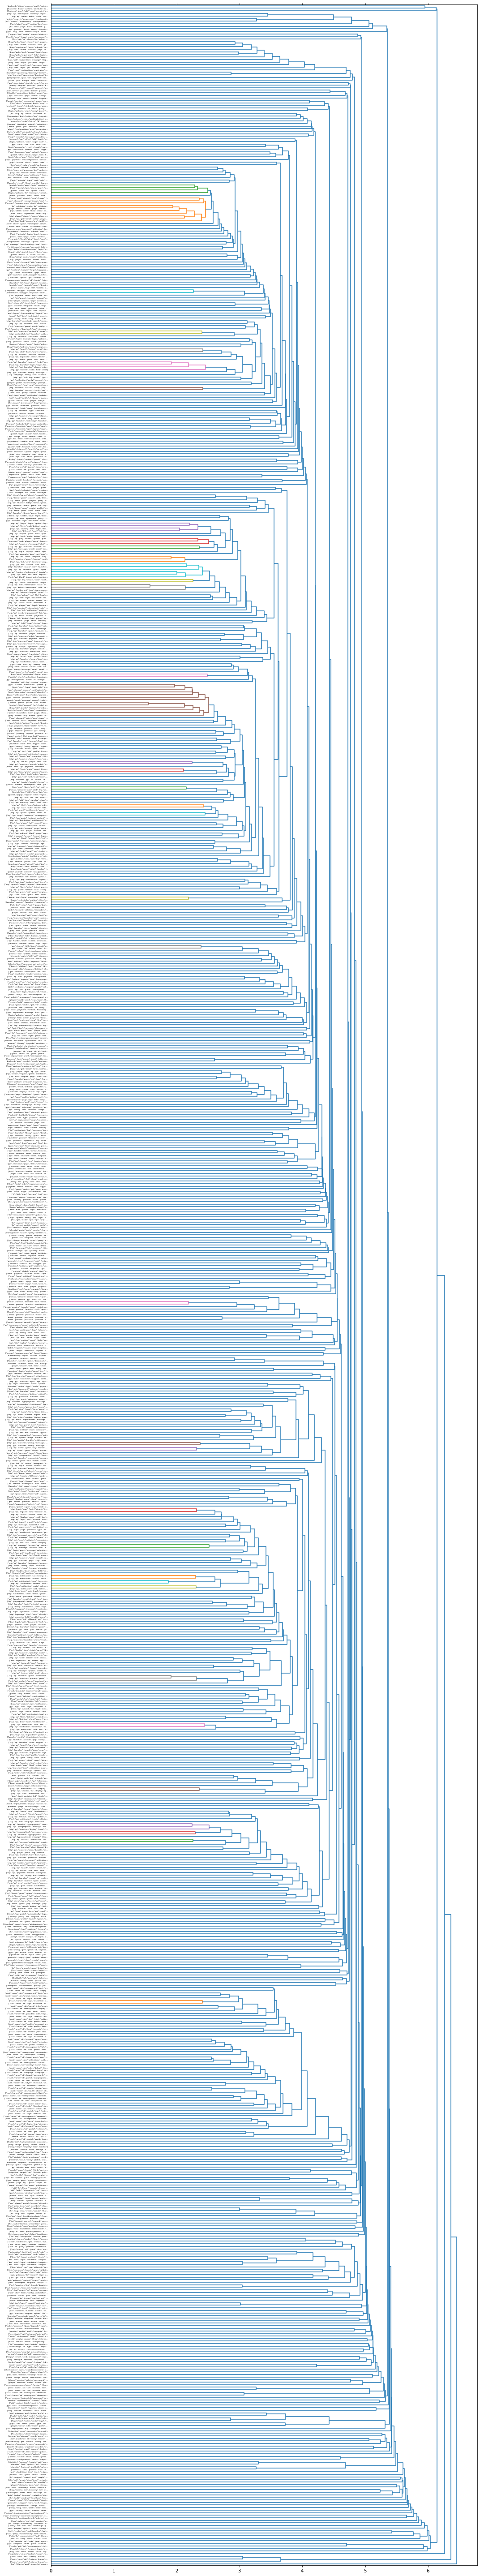

In [35]:
sys.setrecursionlimit(10000)
MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
MAX_TITLE_LEN = 50

fig, ax = plt.subplots(figsize=(15, 80)) # set size
ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
                labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('./Output/jaccard-idf-coeff-weighted.png', dpi=300)

# Analysis

We now take the raw clusters achieved and use the silhouette score and elbow method to evaluate.

In [36]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores

Silhouette score with 2 clusters: -0.7924590158567562
Silhouette score with 3 clusters: -0.9565132394653306
Silhouette score with 4 clusters: -0.9956482832297242
Silhouette score with 5 clusters: -0.995
Silhouette score with 6 clusters: -0.994
Silhouette score with 7 clusters: -0.993
Silhouette score with 8 clusters: -0.992
Silhouette score with 9 clusters: -0.991
Silhouette score with 10 clusters: -0.99
Silhouette score with 11 clusters: -0.989
Silhouette score with 12 clusters: -0.988
Silhouette score with 13 clusters: -0.987
Silhouette score with 14 clusters: -0.986
Silhouette score with 15 clusters: -0.985
Silhouette score with 16 clusters: -0.984
Silhouette score with 17 clusters: -0.983
Silhouette score with 18 clusters: -0.982
Silhouette score with 19 clusters: -0.981
Silhouette score with 20 clusters: -0.98


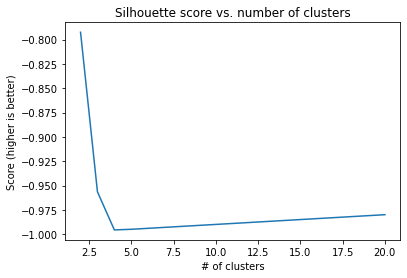

In [37]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)